# JLab ESGF Example Flow

This notebook shows how [Globus Flows](https://www.globus.org/globus-flows-service) and [Globus Compute](https://www.globus.org/compute) can be used to Search and Load CMIP6 Data via ESGF/OPeNDAP.

Globus Flows is a reliable and secure platform for orchestrating and performing research data management and analysis tasks. A flow is often needed to manage data coming from instruments, e.g., image files can be moved from local storage attached to a microscope to a high-performance storage system where they may be accessed by all members of the research project.

More examples of creating and running flows can be found on our [demo instance](https://jupyter.demo.globus.org/hub/).

## Creating a Globus Compute function

We start by defining a Python function that can use the ESGF SearchConnection to load and act on data.

In [79]:
import os
import time
import matplotlib

from globus_compute_sdk import Executor, Client

In [80]:
def esgf_example(project='CMIP6', variant_label='r10i1p1f1', return_path=False):
    import holoviews as hv
    import hvplot.xarray
    from matplotlib import pyplot as plt
    import numpy as np
    import pandas as pd
    from pyesgf.search import SearchConnection
    import xarray as xr

    import os

    xr.set_options(display_style='html')
    hv.extension('bokeh')

    
    conn = SearchConnection('https://esgf-node.llnl.gov/esg-search',
                            distrib=False)

    ctx = conn.new_context(
        facets='project,experiment_id',
        project=project,
        table_id='Amon',
        institution_id="NCAR",
        experiment_id='historical',
        source_id='CESM2',
        variable='tas',
        variant_label=variant_label,
    )


    result = ctx.search()[0]
    
    files = result.file_context().search()

    opendap_urls = [file.opendap_url for file in files]
    
    ds = xr.open_mfdataset(opendap_urls,
                           combine='by_coords',
                           chunks={'time':480})
    
    plt.figure().clear()
    
    result = ds.tas.sel(time='1950-01').squeeze().plot(cmap='Spectral_r');

    # Return the path to the plot when called from within a flow.
    # This is a path rooted at the Demo endpoint used in the flow.
    mapped_path = ""
    if return_path:
        try:
            # ALCF
            os.chdir('/eagle/APSDataAnalysis/DEMO/ESGF')
            mapped_path = "/ESGF"
        except:
            # JLab
            os.chdir(os.path.expanduser('/lustre19/expphy/volatile/IRIBeta/rchard/ESGF'))
            mapped_path = "/expphy/volatile/IRIBeta/rchard/ESGF"

        plt.savefig('esgf_plot.png')
        result = f"{mapped_path}/esgf_plot.png"
    
    return result

Test the function via Globus Compute. I have deployed a GC endpoint on Polaris and installed the dependencies to test this.

To start a GC endpoint at Polaris you need to login, configure a conda environment, and `pip install globus-compute-endpoint`. You can then run `globus-compute-endpoint configure esgf-test; globus-compute-endpoint start esgf-test`. Note that by default your endpoint will execute tasks on the login node. Additional configuration is needed for the endpoint to provision compute nodes: https://globus-compute.readthedocs.io/en/latest/endpoints.html#polaris-alcf

In [87]:
alcf_endpoint_id = '574ab6e4-efad-4c54-beaa-dfa8802fbd02'
jlab_endpoint_id = '870e94b1-efc2-4412-b7d1-bc64d962a105'
test_ep = "9b0b2f6f-0cec-4a9c-afc0-acadf982fb46"

## Run at ALCF

In [88]:
gce = Executor(endpoint_id=test_ep)
fut = gce.submit(esgf_example)

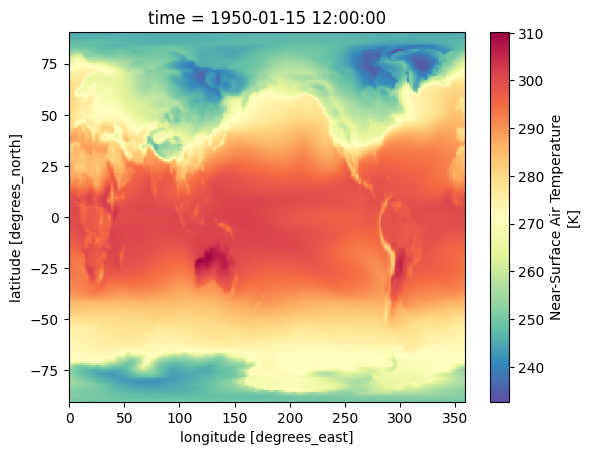

In [89]:
fut.result()

## Run at JLab

This is using a Globus Compute endpoint running on `ifarm1901`. Note: the compute task is so light weight (10s) this is just executed on the login node, not compute nodes.

In [84]:
gce = Executor(endpoint_id=jlab_endpoint_id)
fut = gce.submit(esgf_example)

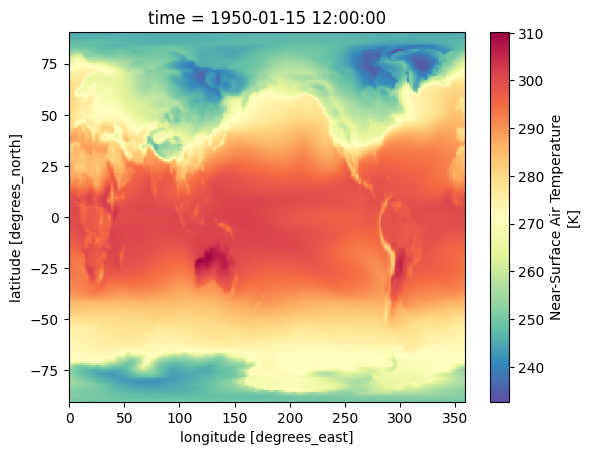

In [85]:
fut.result()

Test it with the `return_path` flag.

In [48]:
fut = gce.submit(esgf_example, return_path=True)
fut.result()

'/expphy/volatile/IRIBeta/rchard/ESGF/esgf_plot.png'

Now that it works, get the uuid for this function.

In [63]:
gc = Client()
esgf_func = gc.register_function(esgf_example)
esgf_func

'1768dd6c-d280-422d-baa3-6c766fe723f2'

## Search for data to determine location

In [50]:
def esgf_search(activity_id='CMIP', member_id=['r10i1p1f1']):
    from intake_esgf import ESGFCatalog
    
    cat = ESGFCatalog().search(
        activity_id=activity_id,
        experiment_id="historical",
        source_id="CESM2",
        variable_id=["gpp", "areacella", "sftlf"],
        member_id=member_id,
    )
    
    # get the location of the first dataset
    data_loc = cat.df['data_node'].values[0]

    return data_loc

In [51]:
fut = gce.submit(esgf_search)
fut.result()

'eagle.alcf.anl.gov'

In [52]:
search_func = gc.register_function(esgf_search)
search_func

'bfc2ee1e-f627-43ca-af92-6c7b0b48e69a'

## Creating a flow

Here we explain how the flow is defined. Running these steps will register a flow of your own that you can then run.

To run these steps you will need to install:

`pip install -U globus_automate_client`

In [18]:
from globus_automate_client import create_flows_client

# Create a flows client to register and run the flow
fc = create_flows_client()

Specify the flow definition. This JSON definition is derived from the Amazon Step Functions language. States of the flow are chained together by specifying the `Next` field to construct a pipeline of operations. This shows a flow that uses Globus Compute to run the above funciton and then transfer the result from ALCF to the Globus Transfer tutorial endpoint, ep1.

In [64]:
flow_definition = {
    "Comment": "A simple Globus Compute flow",
    "StartAt": "ESGFSearch",
    "States": {
        "ESGFSearch": {
            "Comment": "ESGF Search for data",
            "Type": "Action",
            "ActionUrl": "https://compute.actions.globus.org/",
            "Parameters": {
                "endpoint": alcf_endpoint_id,
                "function": search_func,
                "kwargs.$": "$.search_kwargs"
            },
            "ResultPath": "$.ESGF_search_output",
            "WaitTime": 600,
            "Next": "ESGFAnalysis"
        },
#         "FacilityChoice": {
#             "Type" : "Choice",
#             "Choices": [
#             {
#               "Variable": "$.ESGF_search_output.details.result[0]",
#               "StringEquals": "eagle.alcf.anl.gov",
#               "Next": "ALCFAnalysis"
#             },
#           ],
#           "Default": "JLabAnalysis"
#         },
#         "ALCFAnalysis": {
#             "Comment": "ESGF Search and Plot",
#             "Type": "Action",
#             "ActionUrl": "https://compute.actions.globus.org/",
#             "Parameters": {
#                 "endpoint": polaris_endpoint_id,
#                 "function": esgf_func,
#                 "kwargs.$": "$.esgf_kwargs"
#             },
#             "ResultPath": "$.ESGF_output",
#             "WaitTime": 600,
#             "Next": "TransferResult"
#         },
        "ESGFAnalysis": {
            "Comment": "ESGF Search and Plot",
            "Type": "Action",
            "ActionUrl": "https://compute.actions.globus.org/",
            "Parameters": {
                "endpoint.$": "$.compute_endpoint",
                "function": esgf_func,
                "kwargs.$": "$.esgf_kwargs"
            },
            "ResultPath": "$.ESGF_output",
            "WaitTime": 600,
            "Next": "TransferResult"
        },
        "TransferResult": {
            "Comment": "Transfer files",
            "Type": "Action",
            "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
            "Parameters": {
                "source_endpoint_id.$": "$.source.id",
                "destination_endpoint_id.$": "$.destination.id",
                "transfer_items": [
                    {
                        "source_path.$": "$.ESGF_output.details.result[0]",
                        "destination_path.$": "$.destination.path",
                        "recursive": False
                    }
                ]
            },
            "ResultPath": "$.TransferFiles",
            "WaitTime": 300,
            "End": True
        },
    }
}

Register the flow. We leave the input schema blank but can later update it to support the web interface.

In [22]:
flow_id = 'b421208e-243b-4235-a4c9-e016e43a42a3'
flow_scope = 'https://auth.globus.org/scopes/b421208e-243b-4235-a4c9-e016e43a42a3/flow_b421208e_243b_4235_a4c9_e016e43a42a3_user'

# flow = fc.deploy_flow(flow_definition, title="ESGF flow", input_schema={})
# flow_id = flow['id']
# flow_scope = flow['globus_auth_scope']
# print(f'Newly created flow with id:\n{flow_id}\nand scope:\n{flow_scope}')

## Running the flow

We can now specify input and start the flow.

In [53]:
jlab_transfer_endpoint = "b0fca1ad-f485-4a00-8fcd-bca0b93a2a1c"
alcf_transfer_endpoint = "a17d7fac-ce06-4ede-8318-ad8dc98edd69"

In [76]:
# Run at JLab then move the result back to go#ep1

jlab_flow_input = {
     "compute_endpoint": jlab_endpoint_id,
     "search_kwargs": {
          "activity_id": "CMIP",
      },
      "esgf_kwargs": {
          "project": "CMIP6",
          "variant_label": "r10i1p1f1",
          "return_path": True,
      },
      "source": {
          "id": jlab_transfer_endpoint
      },
      "destination": {
          "id": "ddb59aef-6d04-11e5-ba46-22000b92c6ec", #go#ep1
          "path": "/~/esgf_plot.png"
      }
}

In [77]:
# Run at ALCF then move the result back to go#ep1

alcf_flow_input = {
     "compute_endpoint": alcf_endpoint_id,
     "search_kwargs": {
          "activity_id": "CMIP",
      },
      "esgf_kwargs": {
          "project": "CMIP6",
          "variant_label": "r10i1p1f1",
          "return_path": True,
      },
      "source": {
          "id": alcf_transfer_endpoint
      },
      "destination": {
          "id": "ddb59aef-6d04-11e5-ba46-22000b92c6ec", #go#ep1
          "path": "/~/esgf_plot.png"
      }
}

In [78]:
# Run with JLab input

flow_action = fc.run_flow(flow_id, flow_scope, jlab_flow_input, label="JLab ESGF example", tags=["jlab", "esgf", "example"])
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']

print(f'Flow started: https://app.globus.org/runs/{flow_action_id}')

while flow_status == 'ACTIVE':
    time.sleep(30)
    flow_action = fc.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

Flow started: https://app.globus.org/runs/b8a4b61a-6e96-4575-9b3b-e7fdd52e12fc
Flow status: INACTIVE


In [69]:
# Run with ALCF input

flow_action = fc.run_flow(flow_id, flow_scope, alcf_flow_input, label="ALCF ESGF example", tags=["alcf", "esgf", "example"])
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']

print(f'Flow started: https://app.globus.org/runs/{flow_action_id}')

while flow_status == 'ACTIVE':
    time.sleep(30)
    flow_action = fc.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

Flow started: https://app.globus.org/runs/5e54b0f6-052c-4d76-a9ca-e43b2204ccb1
Flow status: ACTIVE
Flow status: SUCCEEDED


In [70]:
flow_action['details']['output']

{'source': {'id': 'a17d7fac-ce06-4ede-8318-ad8dc98edd69'},
 'ESGF_output': {'label': None,
  'status': 'SUCCEEDED',
  'details': {'result': ['/ESGF/esgf_plot.png'],
   'results': [{'output': '/ESGF/esgf_plot.png',
     'task_id': 'ea04c4e2-a321-43ef-932e-645098150bec'}]},
  'action_id': 'tg_55f9de05-a096-41c2-84a4-3cf27787b482',
  'manage_by': ['urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf'],
  'creator_id': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf',
  'monitor_by': ['urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf'],
  'start_time': '2023-09-26T19:47:08.883250+00:00',
  'state_name': 'ESGFAnalysis',
  'release_after': None,
  'display_status': 'All tasks completed',
  'completion_time': '2023-09-26T19:47:35.563852+00:00'},
 'destination': {'id': 'ddb59aef-6d04-11e5-ba46-22000b92c6ec',
  'path': '/~/esgf_plot.png'},
 'esgf_kwargs': {'project': 'CMIP6',
  'return_path': True,
  'variant_label': 'r10i1p1f1'},
 'TransferFiles': {'label'

## Add an input schema for a UI

In [74]:
schema = {
    "required": [
        "destination",
        "source",
        "compute_endpoint"
    ],
    "properties": {
        "compute_endpoint": {
            "type": "string",
            "default": jlab_endpoint_id,
            "additionalProperties": False
        },
        "source": {
            "type": "object",
            "title": "Select result source collection",
            "description": "The source collection to move results from",
            "format": "globus-collection",
            "required": [
                "id",
            ],
            "properties": {
                "id": {
                    "type": "string",
                    "format": "uuid"
                },
            },
            "additionalProperties": False
        },
        "destination": {
            "type": "object",
            "title": "Select destination collection and path",
            "description": "The destination collection and path (path MUST end with a slash); default collection is 'Globus Tutorials on ALCF Eagle'",
            "format": "globus-collection",
            "required": [
                "id",
                "path"
            ],
            "properties": {
                "id": {
                    "type": "string",
                    "format": "uuid"
                },
                "path": {
                    "type": "string"
                }
            },
            "additionalProperties": False
        },
        "esgf_kwargs": {
            "type": "object",
            "title": "ESGF Inputs",
            "description": "Inputs to pass to the ESGF analysis function",
            "required": [
                "project",
                "variant_label",
                "return_path"
            ],
            "properties": {
                "project": {
                    "type": "string",
                    "default": "CMIP6",
                },
                "variant_label": {
                    "type": "string",
                    "default": "r10i1p1f1"
                },
                "return_path": {
                    "type": "boolean",
                    "default": True
                },
            },
            "additionalProperties": False
        },
        "search_kwargs": {
            "type": "object",
            "title": "Search Inputs",
            "description": "Inputs to pass to the Search function",
            "required": [
                "activity_id",
            ],
            "properties": {
                "activity_id": {
                    "type": "string",
                    "default": "CMIP",
                },
            },
            "additionalProperties": False
        }
    },
    "additionalProperties": False
}

In [75]:
# schema = {}
fc.update_flow(flow_id, flow_definition=flow_definition, input_schema=schema)

GlobusHTTPResponse({"id":"b421208e-243b-4235-a4c9-e016e43a42a3","definition":{"Comment":"A simple Globus Compute flow","StartAt":"ESGFSearch","States":{"ESGFSearch":{"Comment":"ESGF Search for data","Type":"Action","ActionUrl":"https://compute.actions.globus.org/","Parameters":{"endpoint":"574ab6e4-efad-4c54-beaa-dfa8802fbd02","function":"bfc2ee1e-f627-43ca-af92-6c7b0b48e69a","kwargs.$":"$.search_kwargs"},"ResultPath":"$.ESGF_search_output","WaitTime":600,"Next":"ESGFAnalysis"},"ESGFAnalysis":{"Comment":"ESGF Search and Plot","Type":"Action","ActionUrl":"https://compute.actions.globus.org/","Parameters":{"endpoint.$":"$.compute_endpoint","function":"1768dd6c-d280-422d-baa3-6c766fe723f2","kwargs.$":"$.esgf_kwargs"},"ResultPath":"$.ESGF_output","WaitTime":600,"Next":"TransferResult"},"TransferResult":{"Comment":"Transfer files","Type":"Action","ActionUrl":"https://actions.automate.globus.org/transfer/transfer","Parameters":{"source_endpoint_id.$":"$.source.id","destination_endpoint_id.$"

## Test it!

In [73]:
print(f'Start flows here: https://app.globus.org/flows/{flow_id}/start')

Start flows here: https://app.globus.org/flows/b421208e-243b-4235-a4c9-e016e43a42a3/start
